# 1. Generative Models for Text

(a) In this problem, we are trying to build a generative model to mimic the writing
style of prominent British Mathematician, Philosopher, prolific writer, and
political activist, Bertrand Russell.



(b) Download the following books from Project Gutenberg http://www.gutenberg.
org/ebooks/author/355 in text format:

i. The Problems of Philosophy

ii. The Analysis of Mind

iii. Mysticism and Logic and Other Essays

iv. Our Knowledge of the External World as a Field for Scientific Method in Philosophy

Project Gutenberg adds a standard header and footer to each book and this is
not part of the original text. Open the file in a text editor and delete the header
and footer.
The header is obvious and ends with the text:
*** START OF THIS PROJECT GUTENBERG EBOOK AN INQUIRY INTO
MEANING AND TRUTH ***
The footer is all of the text after the line of text that says:
THE END
To have a better model, it is strongly recommended that you download the following
books from The Library of Congress https://archive.org and convert
them to text files:

i. The History of Western Philosophy
https://archive.org/details/westernphilosophy4

ii. The Analysis of Matter
https://archive.org/details/in.ernet.dli.2015.221533

iii. An Inquiry into Meaning and Truth
https://archive.org/details/BertrandRussell-AnInquaryIntoMeaningAndTruth

Try to only use the text of the books and throw away unwanted text before and
after the text, although in a large corpus, these are considered as noise and should
not make big problems.


Note:If this is a large corpus for your computer’s power and it makes training LSTM hard, use as many of
the books as possible.


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
downloaded1 = drive.CreateFile({'id':'1gGu4JD7Cv5evlQNswWq1m7fKNKS8Pmg9'})
downloaded1.GetContentFile('book.txt')


In [0]:
import csv 
import pandas as pd
import numpy as np
import string

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint

## (c) LSTM: Train an LSTM to mimic Russell’s style and thoughts:


i. Concatenate your text files to create a corpus of Russell’s writings.


In [0]:
data = ""
with open("book.txt", encoding = 'utf-8') as f:
    for line in f:
        data += line + " "


ii. Use a character-level representation for this model by using extended ASCII
that has N = 256 characters. Each character will be encoded into a an integer
using its ASCII code. Rescale the integers to the range [0, 1], because LSTM uses a sigmoid activation function. LSTM will receive the rescaled integers
as its input.2


2.A smarter way is to parse the whole corpus to figure out how many distinct characters you have in the
corpus (the number may be less than 256, e.g., 53). One can also disregard lowercase and uppercase letters
or even remove punctuation characters such as !.




In [0]:
data = data.lower()
exclude = set(string.punctuation) 
exclude.add('\xa0')
exclude.add('″')
exclude.add('\ufeff')
exclude.add('\n')
data = ''.join(ch for ch in data if ch not in exclude)

In [0]:
data = data[:40000]
unique = sorted(list(set(data)))


In [0]:
print(len(data))
print(unique)


40000
[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [0]:
ref = {}
for ch in unique:
  ref[ch] = unique.index(ch)/len(unique)
  

In [0]:
print(ref)

{' ': 0.0, '0': 0.02702702702702703, '1': 0.05405405405405406, '2': 0.08108108108108109, '3': 0.10810810810810811, '4': 0.13513513513513514, '5': 0.16216216216216217, '6': 0.1891891891891892, '7': 0.21621621621621623, '8': 0.24324324324324326, '9': 0.2702702702702703, 'a': 0.2972972972972973, 'b': 0.32432432432432434, 'c': 0.35135135135135137, 'd': 0.3783783783783784, 'e': 0.40540540540540543, 'f': 0.43243243243243246, 'g': 0.4594594594594595, 'h': 0.4864864864864865, 'i': 0.5135135135135135, 'j': 0.5405405405405406, 'k': 0.5675675675675675, 'l': 0.5945945945945946, 'm': 0.6216216216216216, 'n': 0.6486486486486487, 'o': 0.6756756756756757, 'p': 0.7027027027027027, 'q': 0.7297297297297297, 'r': 0.7567567567567568, 's': 0.7837837837837838, 't': 0.8108108108108109, 'u': 0.8378378378378378, 'v': 0.8648648648648649, 'w': 0.8918918918918919, 'x': 0.918918918918919, 'y': 0.9459459459459459, 'z': 0.972972972972973}


In [0]:
len(ref.keys())

37

iii. Choose a window size, e.g., W = 100.

In [0]:
window = 100
ip = data
lstm_ip = [ref[x] for x in ip]
lstm_ip[:10], ip[:10]

([0.35135135135135137,
  0.4864864864864865,
  0.2972972972972973,
  0.7027027027027027,
  0.8108108108108109,
  0.40540540540540543,
  0.7567567567567568,
  0.0,
  0.5135135135135135,
  0.0],
 'chapter i ')

In [0]:
columns = range(1,window)

lstm_x = pd.DataFrame(columns=columns)
for i in columns:
  lstm_x[i] = lstm_ip[i-1:-window+i-1]
lstm_x.shape

(39900, 99)

In [0]:
ref.values()

dict_values([0.0, 0.02702702702702703, 0.05405405405405406, 0.08108108108108109, 0.10810810810810811, 0.13513513513513514, 0.16216216216216217, 0.1891891891891892, 0.21621621621621623, 0.24324324324324326, 0.2702702702702703, 0.2972972972972973, 0.32432432432432434, 0.35135135135135137, 0.3783783783783784, 0.40540540540540543, 0.43243243243243246, 0.4594594594594595, 0.4864864864864865, 0.5135135135135135, 0.5405405405405406, 0.5675675675675675, 0.5945945945945946, 0.6216216216216216, 0.6486486486486487, 0.6756756756756757, 0.7027027027027027, 0.7297297297297297, 0.7567567567567568, 0.7837837837837838, 0.8108108108108109, 0.8378378378378378, 0.8648648648648649, 0.8918918918918919, 0.918918918918919, 0.9459459459459459, 0.972972972972973])

In [0]:
lstm_op = pd.Series(lstm_ip[window-1:-1])
lstm_op
lstm_y = pd.get_dummies(lstm_op, columns = ref.values())
lstm_y.shape


(39900, 37)

iv. Inputs to the network will be the first W −1 = 99 characters of each sequence,
and the output of the network will be the L
th character of the sequence.
Basically, we are training the network to predict the each character using the
99 characters that precede it. Slide the window in strides of S = 1 on the
text. For example, if W = 5 and S = 1 and we want to train the network
with the sequence ABRACADABRA, The first input to the network will be
ABRA and the corresponding output will be C. The second input will be
BRAC and the second output will be A, etc

v. Note that the output has to be encoded using a one-hot encoding scheme with
N = 256 (or less) elements. This means that the network reads integers, but
outputs a vector of N = 256 (or less) elements.

vi. Use a single hidden layer for the LSTM with N = 256 (or less) memory units.

vii. Use a Softmax output layer to yield a probability prediction for each of the
characters between 0 and 1. This is actually a character classification problem
with N classes. Choose log loss (cross entropy) as the objective function for
the network (research what it menas).3


3
In Keras, you can use the ADAM optimization algorithm for speed.


ix. Choose a reasonable number of epochs for training (e.g., 30, although the
network will need more epochs to yield a better model).

viii. We do not use a test dataset. We are using the whole training dataset to
learn the probability of each character in a sequence. We are not seeking for
a very accurate model of. Instead we are interested in a generalization of the
dataset that can mimic the gist of the text.

In [0]:
def create_model(input_shape, unique_chars):
    regressor = Sequential()
    regressor.add(LSTM(units = unique_chars, return_sequences = False, input_shape = (input_shape, 1)))
    regressor.add(Dropout(0.1))
    regressor.add(Dense(units = unique_chars, activation ='softmax'))
    optimizer = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
    regressor.compile(optimizer = optimizer, loss = 'categorical_crossentropy')
    return regressor

In [0]:
regressor = create_model(input_shape = window-1, unique_chars = len(ref.keys()))
regressor

In [0]:
lstm_x_ = np.array(lstm_x).reshape(-1, 99, 1)

In [0]:
regressor.fit(lstm_x_, lstm_y, validation_split=0.2, epochs=30, shuffle=True, window=1000, verbose=1)

Train on 31920 samples, validate on 7980 samples
Epoch 1/30
31920/31920 [==============================] - 9s 293us/step - loss: 2.8787 - val_loss: 2.7727
Epoch 2/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.7229 - val_loss: 2.6754
Epoch 3/30
31920/31920 [==============================] - 8s 266us/step - loss: 2.6525 - val_loss: 2.6194
Epoch 4/30
31920/31920 [==============================] - 9s 268us/step - loss: 2.6109 - val_loss: 2.5832
Epoch 5/30
31920/31920 [==============================] - 9s 268us/step - loss: 2.5812 - val_loss: 2.5692
Epoch 6/30
31920/31920 [==============================] - 9s 268us/step - loss: 2.5620 - val_loss: 2.5439
Epoch 7/30
28000/31920 [=========================>....] - ETA: 0s - loss: 2.5418

31920/31920 [==============================] - 9s 271us/step - loss: 2.5440 - val_loss: 2.5142
Epoch 8/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.5253 - val_loss: 2.4928
Epoch 9/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.5041 - val_loss: 2.4776
Epoch 10/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.4825 - val_loss: 2.4804
Epoch 11/30
31920/31920 [==============================] - 9s 268us/step - loss: 2.4721 - val_loss: 2.4617
Epoch 12/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.4517 - val_loss: 2.4412
Epoch 13/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.4455 - val_loss: 2.4264
Epoch 14/30
14000/31920 [============>.................] - ETA: 4s - loss: 2.4213

31920/31920 [==============================] - 9s 269us/step - loss: 2.4303 - val_loss: 2.4075
Epoch 15/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.4032 - val_loss: 2.3913
Epoch 16/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.3994 - val_loss: 2.3887
Epoch 17/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.3812 - val_loss: 2.3905
Epoch 18/30
31920/31920 [==============================] - 9s 268us/step - loss: 2.3729 - val_loss: 2.3685
Epoch 19/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.3537 - val_loss: 2.3511
Epoch 20/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.3516 - val_loss: 2.3448
Epoch 21/30
12000/31920 [==========>...................] - ETA: 5s - loss: 2.3256

31920/31920 [==============================] - 9s 269us/step - loss: 2.3373 - val_loss: 2.3516
Epoch 22/30
31920/31920 [==============================] - 8s 264us/step - loss: 2.3354 - val_loss: 2.3455
Epoch 23/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.3202 - val_loss: 2.3334
Epoch 24/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.3079 - val_loss: 2.3234
Epoch 25/30
31920/31920 [==============================] - 8s 266us/step - loss: 2.3055 - val_loss: 2.3236
Epoch 26/30
31920/31920 [==============================] - 8s 266us/step - loss: 2.2911 - val_loss: 2.2998
Epoch 27/30
31920/31920 [==============================] - 8s 265us/step - loss: 2.2819 - val_loss: 2.3222
Epoch 28/30
12000/31920 [==========>...................] - ETA: 4s - loss: 2.2788

31920/31920 [==============================] - 8s 263us/step - loss: 2.2818 - val_loss: 2.2951
Epoch 29/30
31920/31920 [==============================] - 8s 266us/step - loss: 2.2756 - val_loss: 2.2938
Epoch 30/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.2691 - val_loss: 2.2914


In [0]:
pred = regressor.predict(lstm_x_[0:100])
for vec in pred:
    print(unique[np.where(vec == max(vec))[0][0]], end="")
print()
for vec in np.array(lstm_y[:100]):
    print(unique[np.where(vec == max(vec))[0][0]], end="")


hali  tle tojebe    tnren ie the  to se  n th ch tn an e etheneein e eto  thel tnf eri e te thelc  i
easonable man could doubt it this question which at first sight might not seem difficult is really o

 SAMPLE 3
 eelen  l  tfteiele  teret tn thes ier    n thech te teee  the   of    te  the  teniecel  tn thelen t
easonable man could doubt it this question which at first sight might not seem difficult is really o

SAMPLE 2
hesen     tnteted   tere  tn the  toeet nn thech t  te e  the e of e  te ethe  terfecul  tn thes   t
easonable man could doubt it this question which at first sight might not seem difficult is really o

Sample 1
(100, 37) (100, 37)
he en     to eae en te    tn the  ae ee  g th ch te te ee th    of    tf  the  te  erea  tn the    t
easonable man could doubt it this question which at first sight might not seem difficult is really o

x. Use model checkpointing to keep the network weights to determine each time
an improvement in loss is observed at the end of the epoch. Find the best set
of weights in terms of loss.

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
 regressor.fit(lstm_x_, lstm_y, validation_split=0.2, epochs=30, shuffle=True, batch_size=1000, callbacks=callbacks_list, verbose=1)

Train on 31920 samples, validate on 7980 samples
Epoch 1/30
31920/31920 [==============================] - 8s 259us/step - loss: 2.2705 - val_loss: 2.2919

Epoch 00001: val_loss improved from inf to 2.29188, saving model to weights.best.hdf5
Epoch 2/30
31920/31920 [==============================] - 9s 268us/step - loss: 2.2626 - val_loss: 2.2857

Epoch 00002: val_loss improved from 2.29188 to 2.28566, saving model to weights.best.hdf5
Epoch 3/30
31920/31920 [==============================] - 9s 268us/step - loss: 2.2516 - val_loss: 2.2844

Epoch 00003: val_loss improved from 2.28566 to 2.28439, saving model to weights.best.hdf5
Epoch 4/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.2572 - val_loss: 2.2861

Epoch 00004: val_loss did not improve from 2.28439
Epoch 5/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.2430 - val_loss: 2.2729

Epoch 00005: val_loss improved from 2.28439 to 2.27285, saving model to weights.best.hdf5
Epoch 6/3

31920/31920 [==============================] - 9s 267us/step - loss: 2.2398 - val_loss: 2.2751

Epoch 00006: val_loss did not improve from 2.27285
Epoch 7/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.2356 - val_loss: 2.2690

Epoch 00007: val_loss improved from 2.27285 to 2.26902, saving model to weights.best.hdf5
Epoch 8/30
31920/31920 [==============================] - 9s 266us/step - loss: 2.2297 - val_loss: 2.2539

Epoch 00008: val_loss improved from 2.26902 to 2.25390, saving model to weights.best.hdf5
Epoch 9/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.2230 - val_loss: 2.2644

Epoch 00009: val_loss did not improve from 2.25390
Epoch 10/30
31920/31920 [==============================] - 9s 270us/step - loss: 2.2295 - val_loss: 2.2574

Epoch 00010: val_loss did not improve from 2.25390
Epoch 11/30
31920/31920 [==============================] - 9s 267us/step - loss: 2.2213 - val_loss: 2.2621



Epoch 00011: val_loss did not improve from 2.25390
Epoch 12/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.2196 - val_loss: 2.2643

Epoch 00012: val_loss did not improve from 2.25390
Epoch 13/30
31920/31920 [==============================] - 9s 271us/step - loss: 2.2279 - val_loss: 2.2510

Epoch 00013: val_loss improved from 2.25390 to 2.25099, saving model to weights.best.hdf5
Epoch 14/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.2083 - val_loss: 2.2424

Epoch 00014: val_loss improved from 2.25099 to 2.24244, saving model to weights.best.hdf5
Epoch 15/30
31920/31920 [==============================] - 9s 272us/step - loss: 2.2094 - val_loss: 2.2623

Epoch 00015: val_loss did not improve from 2.24244
Epoch 16/30
31920/31920 [==============================] - 9s 271us/step - loss: 2.2216 - val_loss: 2.2418

Epoch 00016: val_loss improved from 2.24244 to 2.24178, saving model to weights.best.hdf5
Epoch 17/30
17000/31920 [===========

31920/31920 [==============================] - 9s 269us/step - loss: 2.2084 - val_loss: 2.2209

Epoch 00017: val_loss improved from 2.24178 to 2.22092, saving model to weights.best.hdf5
Epoch 18/30
31920/31920 [==============================] - 9s 271us/step - loss: 2.2000 - val_loss: 2.2221

Epoch 00018: val_loss did not improve from 2.22092
Epoch 19/30
31920/31920 [==============================] - 9s 272us/step - loss: 2.1940 - val_loss: 2.2375

Epoch 00019: val_loss did not improve from 2.22092
Epoch 20/30
31920/31920 [==============================] - 9s 272us/step - loss: 2.1940 - val_loss: 2.2135

Epoch 00020: val_loss improved from 2.22092 to 2.21351, saving model to weights.best.hdf5
Epoch 21/30
31920/31920 [==============================] - 9s 270us/step - loss: 2.1951 - val_loss: 2.2286

Epoch 00021: val_loss did not improve from 2.21351
Epoch 22/30
31000/31920 [============================>.] - ETA: 0s - loss: 2.1949

31920/31920 [==============================] - 9s 269us/step - loss: 2.1954 - val_loss: 2.2102

Epoch 00022: val_loss improved from 2.21351 to 2.21022, saving model to weights.best.hdf5
Epoch 23/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.2024 - val_loss: 2.2077

Epoch 00023: val_loss improved from 2.21022 to 2.20768, saving model to weights.best.hdf5
Epoch 24/30
31920/31920 [==============================] - 9s 268us/step - loss: 2.1855 - val_loss: 2.2200

Epoch 00024: val_loss did not improve from 2.20768
Epoch 25/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.1889 - val_loss: 2.2216

Epoch 00025: val_loss did not improve from 2.20768
Epoch 26/30
31920/31920 [==============================] - 9s 270us/step - loss: 2.1830 - val_loss: 2.1992

Epoch 00026: val_loss improved from 2.20768 to 2.19916, saving model to weights.best.hdf5
Epoch 27/30
18000/31920 [===============>..............] - ETA: 3s - loss: 2.1668

31920/31920 [==============================] - 9s 268us/step - loss: 2.1745 - val_loss: 2.1835

Epoch 00027: val_loss improved from 2.19916 to 2.18349, saving model to weights.best.hdf5
Epoch 28/30
31920/31920 [==============================] - 9s 269us/step - loss: 2.1810 - val_loss: 2.2107

Epoch 00028: val_loss did not improve from 2.18349
Epoch 29/30
31920/31920 [==============================] - 9s 272us/step - loss: 2.1731 - val_loss: 2.1753

Epoch 00029: val_loss improved from 2.18349 to 2.17528, saving model to weights.best.hdf5
Epoch 30/30
31920/31920 [==============================] - 9s 273us/step - loss: 2.1666 - val_loss: 2.2256

Epoch 00030: val_loss did not improve from 2.17528


xi. Use the network with the best weights to generate 1000 characters, using the
following text as initialization of the network:
There are those who take mental phenomena naively, just as they
would physical phenomena. This school of psychologists tends not to
emphasize the object.

In [0]:
regressor.load_weights("weights.best.hdf5")
pred = regressor.predict(lstm_x_[0:100])
for vec in pred:
    print(unique[np.where(vec == max(vec))[0][0]], end="")
print()
for vec in np.array(lstm_y[:100]):
    print(unique[np.where(vec == max(vec))[0][0]], end="")


halon     ifvetenl  tense tn the  torse on ih ch tn tere  the   tf e  tf  thesetoffnculnein thally t
easonable man could doubt it this question which at first sight might not seem difficult is really o

In [0]:
test = "There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object"


for i in range(100):
    hold = test.lower()[-100:]
    exclude = set(string.punctuation) 
    exclude.add('\xa0')
    exclude.add('″')
    exclude.add('\ufeff')
    exclude.add('\n')
    hold = ''.join(ch for ch in hold if ch not in exclude)
    lstm_hold = np.array([ref[x] for x in hold])
    lstm_hold = lstm_hold[-99:]
    lstm_hold = lstm_hold.reshape(1, 99, 1)
    
    predicting = regressor.predict(lstm_hold)
    for vec in predicting:
        print(unique[np.where(vec == max(vec))[0][0]], end="")
        test += unique[np.where(vec == max(vec))[0][0]]
  
  

 the table and the table and the table and the table and the table and the table and the table and t

# 2. (Deep) CNNs for Image Colorization


In [0]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
   print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [0]:
def unpickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
    return data


def load_cifar10_data():
    train_data = None
    train_labels = []

    for i in range(1, 6):
        data_dic = unpickle(data_dir + "data_batch_{}".format(i))
        if i == 1:
            train_data = data_dic['data']
        else:
            train_data = np.vstack((train_data, data_dic['data']))
        train_labels += data_dic['labels']
    test_data_dic = unpickle(data_dir + "test_batch")
    test_data = test_data_dic['data']
    test_labels = test_data_dic['labels']

    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)

    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)

    return train_data, train_labels, test_data, test_labels

In [0]:
def kmean():
      window, t1, t2, t3 = original_shape = tuple(bird.shape)
      assert t3 == 3
      img = np.reshape(bird, (window * t1 * t2, t3))
      clf = KMeans(n_clusters=4,n_init=3, max_iter=300)
      clf.fit(img)
      labels = clf.labels_
      centroids = clf.cluster_centers_
      result = [] 
          for idx, i in enumerate(labels):     
              pad = np.zeros(4)     
              index = [i]     
              pad[index] = 1     
              result.append(pad)
    

In [0]:
def clr2gray():
  for index, i in enumerate(bird):
    if index == 0:
        g_ar = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
        g_ar = np.expand_dims(np.expand_dims(g_ar,axis=0), axis = -1)
    else:
        color_convert = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
        g_ar = np.vstack((g_ar, np.expand_dims(np.expand_dims(color_convert, axis=0), axis = -1)))

(a) This assignment uses a convolutional neural network for image colorization which
turns a grayscale image to a colored image.4 By converting an image to grayscale,
we loose color information, so converting a grayscale image back to a colored
version is not an easy job. We will use the CIFAR-10 dataset. Downolad the
dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

4MATLAB seems to have an easy to use CNN library. https://www.mathworks.com/help/nnet/
examples/train-a-convolutional-neural-network-for-regression.html
3


In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dropout, MaxPooling2D, Conv2D, Dense, LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
train_data, train_labels, test_data, test_labels = load_cifar10_data()
print(train_data.shape) 
print(train_labels.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)


 data shape

(b) From the train and test dataset, extract the class birds. We will focus on this
class, which has 6000 members.

In [0]:
train_data, train_labels = train_data[train_labels == 2], train_labels[train_labels == 2]
test_data, test_labels = test_data[test_labels == 2] , test_labels[test_labels==2]

(c) Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels
randomly. It is strongly recommended that you choose a large number or all of
the pixels. You will have between P = 614400 and P = 6144000 pixels. Each
pixel is an RGB vector with three elements.

Using all pixels

Loading all bird data together

In [0]:
bird = np.vstack((train_data, test_data))
bird.shape

(6000, 32, 32, 3)

(d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters
will be your main colors. Convert the colored images to k-color images by converting
each pixel’s value to the closest main color in terms of Euclidean distance.
These are the outputs of your network, whose each pixel falls in one of those k
classes.

In [0]:
kmean()
y_train = np.array(result)
y_train = np.reshape(y_train,(6000,32,32,4))
y_train.shape

(6000, 32, 32, 4)

(e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images
from the original 32 × 32 × 3 images. The grayscale images are inputs of your
network.

In [0]:
clr2gray()       
g_ar.shape

(6000, 32, 32, 1)

(f) Set up a deep convolutional neural network with two convolution layers and two
MLP layers with. Use 5 × 5 filters and a softmax layer. Determine the number
of filters, strides, and whether or not to use padding yourself. Use a minimum of
one max pooling layer. Your input is a grayscale version of an image (32×32×1)
and the output is a 32×32×3 image that is colored using the main colors. Use a
classification scheme, which means your output must determine one of the k color
classes for each pixel in your grayscale image. Train at least for 5 epochs. Plot
training, (validation), and test errors in each epoch. Report the train and test
errors and visually compare the artificially colored versions of the first 10 images
in the test set with the original images.

In [0]:
#Building a CNN
cnn = Sequential()
cnn.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same', input_shape = (32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
cnn.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same'))
cnn.add(Dense(36, activation='softmax'))
cnn.add(Dense(4, activation='softmax'))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
dense_27 (Dense)             (None, 32, 32, 36)        2340      
_________________________________________________________________
dense_28 (Dense)             (None, 32, 32, 4)         148       
Total params: 106,616
Trainable params: 106,616
Non-trainable params: 0
_________________________________________________________________


Train on 3347 samples, validate on 1650 samples
Epoch 1/10
3347/3347 [==============================] - 4s 1ms/step - loss: 1.3640 - acc: 0.3690 - val_loss: 1.3463 - val_acc: 0.3711
Epoch 2/10
3347/3347 [==============================] - 4s 1ms/step - loss: 1.3294 - acc: 0.3877 - val_loss: 1.3098 - val_acc: 0.3863
Epoch 3/10
3347/3347 [==============================] - 4s 1ms/step - loss: 1.3109 - acc: 0.4014 - val_loss: 1.3103 - val_acc: 0.3951
Epoch 4/10
3347/3347 [==============================] - 4s 1ms/step - loss: 1.2945 - acc: 0.4104 - val_loss: 1.3034 - val_acc: 0.3921
Epoch 5/10
2528/3347 [=====================>........] - ETA: 0s - loss: 1.2785 - acc: 0.4144

3347/3347 [==============================] - 4s 1ms/step - loss: 1.2777 - acc: 0.4185 - val_loss: 1.2679 - val_acc: 0.4206
Epoch 6/10
3347/3347 [==============================] - 4s 1ms/step - loss: 1.2682 - acc: 0.4185 - val_loss: 1.2590 - val_acc: 0.4188
Epoch 7/10
3347/3347 [==============================] - 4s 1ms/step - loss: 1.2551 - acc: 0.4195 - val_loss: 1.2586 - val_acc: 0.3918
Epoch 8/10
3347/3347 [==============================] - 4s 1ms/step - loss: 1.2467 - acc: 0.4180 - val_loss: 1.2529 - val_acc: 0.4199
Epoch 9/10
3347/3347 [==============================] - 4s 1ms/step - loss: 1.2357 - acc: 0.4193 - val_loss: 1.2284 - val_acc: 0.4180
Epoch 10/10
 800/3347 [======>.......................] - ETA: 2s - loss: 1.2372 - acc: 0.4150

3347/3347 [==============================] - 4s 1ms/step - loss: 1.2271 - acc: 0.4199 - val_loss: 1.2334 - val_acc: 0.3818


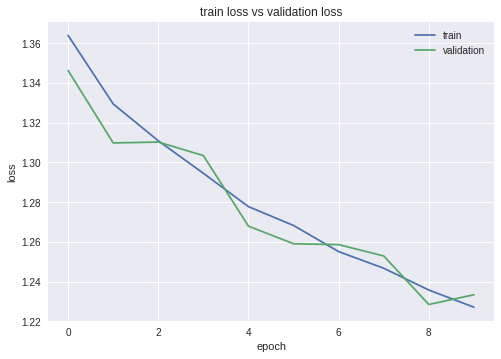

In [0]:
cnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics = ['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(g_ar, y_train,test_size=0.167)
prev = cnn.fit(X_train, y_train, epochs=10, validation_split=0.33)
cnn.save_weights("model.h5")
plt.plot(prev.history['loss'])
plt.plot(prev.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
cnn.load_weights("model.h5")
res_ = []
acc_ = []
pre_ = []
for x, y in zip(X_test,y_test):
    pred = cnn.predict(np.expand_dims(x, axis=0))
    result = [] 
    for i in np.reshape(pred, (-1, 4)):
        index = [np.argmax(i)]
        pad = np.zeros(4)
        pad[index] =1
        result.append(pad)
    
    acc = accuracy_score(np.array([np.argmax(i) for i in np.reshape(np.array(result), (-1,4))]), np.array([np.argmax(i) for i in np.reshape(y,(-1,4))]))
    res_.append(result)
    acc_.append(acc)
    pre_.append(pred)
test_error = 1- np.average(np.array(acc_))
test_error

0.6240273320663011

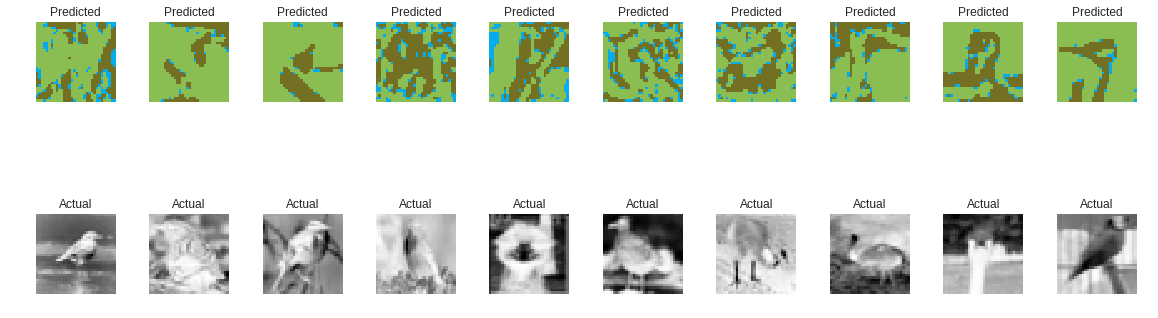

In [0]:
fig,row = plt.subplots(nrows = 3, ncols = 10, figsize=(20,5))
for ax in row.flatten():
    ax.axis('off')
    
for j in range(10):
    row[0,j].imshow(np.reshape(np.array([centroids[np.argmax(i)] for i in np.reshape(prediction[j], (-1,4))]), (32,32,-1)))
    row[0,j].set_title('Predicted')
    row[2,j].imshow(np.squeeze(X_test[j]))
    row[2,j].set_title('Actual')    
plt.show()